# Morphological Image Processing

Erosion and dilation

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import skimage
import skimage.morphology as mp
import scipy.ndimage.morphology as morp
from copy import deepcopy

def plot_image(image):
    plt.imshow(image, cmap=plt.cm.binary)
    plt.show()
    
def histo2(image):
    plt.hist(image.ravel(), bins=256, range=(0, 256), fc='k', ec='k')
    plt.show()

def mean_threshold(image, threshold=None):
    image = deepcopy(image)
    if threshold is None:
        threshold = image.mean()
    print("Threshold:", int(threshold))
    image[image >= threshold] = 255
    image[image < threshold] = 0
    return image

Threshold: 76


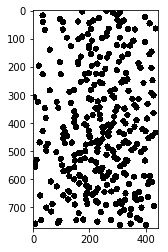

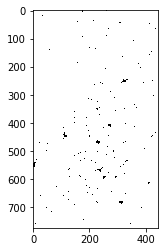

In [6]:
coins_img = mean_threshold(cv2.imread("coins.jpg", cv2.IMREAD_GRAYSCALE))
kernel1 = mp.disk(radius=10)
kernel2 = mp.disk(radius=5)
plot_image(coins_img)
coins_eroded = cv2.erode(coins_img, kernel1)
# coins_new = cv2.dilate(coins_eroded, kernel2)
plot_image(coins_eroded)
# plot_image(coins_new)

# lol_img = np.zeros((256, 256), dtype="uint8")
# plot_image(lol_img)

In [7]:
ret, thresh = cv2.threshold(coins_eroded,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
output = cv2.connectedComponentsWithStats(thresh, 8, cv2.CV_32S)
print("coins total:", output[0])

# coins_zero = np.zeros_like(coins_img)
# for y,x in output[3]:
#     coins_zero[int(x), int(y)] = 255
# plot_image(cv2.dilate(coins_zero, kernel2))

def find_blobs(image):
    ret, thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY)
    output = cv2.connectedComponentsWithStats(thresh, 8, cv2.CV_32S)
    return output[0]

coins total: 272


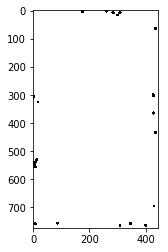

border coins: 21


In [8]:
border = 18
coins_border = deepcopy(coins_eroded)
coins_border[border:coins_img.shape[0] - border, border:coins_img.shape[1] - border] = 0
plot_image(cv2.dilate(coins_border, mp.disk(5)))
print("border coins:", find_blobs(coins_border))

# plot_image(cv2.dilate(cv2.erode(coins_border, mp.disk(7)), mp.disk(3)))

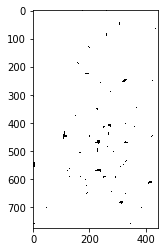

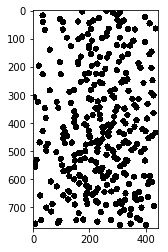

In [89]:
# NON OVERLAPPING
erode1 = cv2.erode(coins_img, np.ones((15,15)).astype("uint8"))
erode2 = cv2.erode(erode1, mp.disk(1))
plot_image(erode2)
plot_image(coins_img)

Threshold: 54


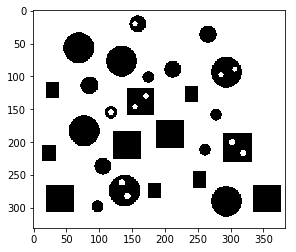

Objects with holes: 6
Square objects: 11
Square objects with holes: 2
Circle objects with no holes: 13


In [77]:
# OBJECT WITH HOLES
# SQUARES
# SQUARES WITH HOLES
# CIRCLES WITHOUT HOLES

objects_img = mean_threshold(cv2.imread("objects.png", cv2.IMREAD_GRAYSCALE))
plot_image(objects_img)

obj_new = mp.closing(objects_img, mp.disk(5))
obj_new = cv2.erode(obj_new, mp.disk(5))
# plot_image(obj_new)

def find_conn(img):
    img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY)[1]
    return cv2.connectedComponents(img)

h,w = objects_img.shape[:2]

image_new = np.zeros((h,w,3), dtype="uint8")

num_objects, labels_hole = find_conn(objects_img)
_, labels_full = find_conn(obj_new)

def object_has_hole(label_num, images, labels):
    inner_objects = [0,0]
    images = deepcopy(images)
    for i in range(2):
        images[i][labels[i] != label_num] = 0
        images[i] = np.logical_not(images[i])
        inner_objects[i] = find_conn(images[i])[0]
    
    if(inner_objects[0] >= 1 and inner_objects[1] >= 1 and inner_objects[0] != inner_objects[1]):
        return True
    return False

def edge_sobel(image, axis=0):
    sobel_filters = np.array([
        [[-1,-2,-1],
        [0,0,0],
        [1,2,1]],
        
        [[-1,0,1],
        [-2,0,2],
        [-1,0,1]]
    ])
    
    return cv2.filter2D(image, -1, sobel_filters[axis])

def object_is_square(label_num, image, labels):
    image = deepcopy(image)
    image[labels != label_num] = 0
    i1 = edge_sobel(image, 0)
    for meow in range(5):
        i1 = cv2.erode(i1, np.ones((1,5)).astype("uint8"))
    
    i2 = edge_sobel(image, 1)
    for meow in range(5):
        i2 = cv2.erode(i2, np.ones((5,1)).astype("uint8"))
    return i1.astype("bool").sum() > 1 and i2.astype("bool").sum() > 1

# object_is_square(5, objects_img, labels)

objects_with_hole = 0
square_objects = 0
square_hole = 0
circle_no_hole = 0

for i in range(retval):
    has_hole = object_has_hole(i, np.array([objects_img, obj_new]), [labels_hole, labels_full])
    is_square = object_is_square(i, objects_img, labels)
    objects_with_hole += has_hole
    square_objects += is_square
    square_hole += is_square and has_hole
    circle_no_hole += not is_square and not has_hole
    
print("Objects with holes:", objects_with_hole)
print("Square objects:", square_objects)
print("Square objects with holes:", square_hole)
print("Circle objects with no holes:", circle_no_hole)

# Geometric Image Processing

Chroma image

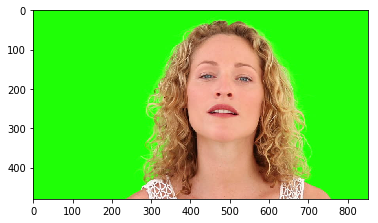

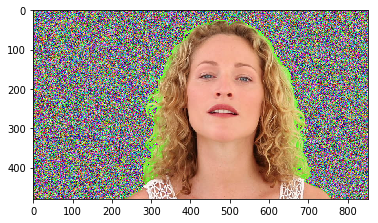

In [352]:
def bgr_rgb(image):
    im2 = np.zeros_like(image)
    im2[:,:,2] = deepcopy(image[:,:,0])
    im2[:,:,0] = deepcopy(image[:,:,2])
    im2[:,:,1] = deepcopy(image[:,:,1])
    return im2

def histoRGB(image):
    plt.hist(image[:,:,0].ravel(), bins=256, range=(0, 256), fc='r', ec='r')
    plt.hist(image[:,:,1].ravel(), bins=256, range=(0, 256), fc='g', ec='g')
    plt.hist(image[:,:,2].ravel(), bins=256, range=(0, 256), fc='b', ec='b')
    plt.show()

im1 = bgr_rgb(cv2.imread("chroma_img.jpg", cv2.IMREAD_COLOR))

plot_image(im1)

# histoRGB(im1)
def chroma_key(image, axis=1, threshold=255, back=None):
    color_image = np.zeros_like(image)
    color_image[:,:,axis] = threshold
    if back is None:
        # random background
        back = np.random.randint(low=0, high=255, size=image.shape).astype("uint8")
    criteria = color_image[:,:,axis] != image[:,:,axis]
    back[criteria] = image[criteria]
    return back
    
plot_image(chroma_key(im1))

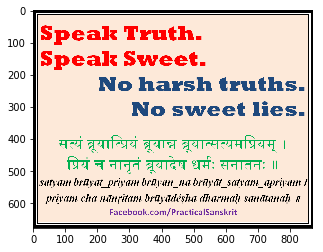

Red: 25
Blue: 28
Black: 244
Green: 75
Purple: 35


In [351]:
im_text = bgr_rgb(cv2.imread("text2.png", cv2.IMREAD_COLOR))

def get_mask(image, back_pixel=(0,0,0)):
    back_mask = np.ones((image.shape[0], image.shape[1]), dtype="bool")
    for i in range(3):
        back_mask = np.logical_and(image[:,:,i] == back_pixel[i], back_mask)
    return back_mask

def encode_color_image(image):
    encoded = np.zeros((image.shape[0], image.shape[1]), dtype="int")
    for i in range(3):
        encoded += image[:,:,i].astype("int")*(256**i)
    return encoded

def decode_color(enc_color):
    color = np.zeros((3), dtype="uint8")
    for i in range(3):
        color[i] = enc_color%256
        enc_color = int(enc_color/256)
    return color

def thresh(image, pixel=(100,100,100), signs=(0,0,0)):
    h, w = image.shape[:2]
    mask = np.ones((h,w), dtype="bool")
    for i in range(3):
        if signs[i] == 0:
            mask = np.logical_and(image[:,:,i] < pixel[i], mask)
        else:
            mask = np.logical_and(image[:,:,i] > pixel[i], mask)
    return (mask*255).astype("uint8")

def thresh_range(image, pixel1=(100,100,100), pixel2=None):
    h, w = image.shape[:2]
    pixel1 = np.array(pixel1)
    if pixel2 is None:
        pixel2 = pixel1 + 5
        pixel1 = pixel1 - 5
    elif type(pixel2) == int:
        th = pixel2
        pixel2 = pixel1 + th
        pixel1 = pixel1 - th
    mask = np.ones((h,w), dtype="bool")
    for i in range(3):
        mini, maxi = min(pixel1[i], pixel2[i]), max(pixel1[i], pixel2[i])
        mask = np.logical_and(image[:,:,i] <= maxi, mask)
        mask = np.logical_and(image[:,:,i] >= mini, mask)
    return (mask*255).astype("uint8")

im_red = thresh(im_text, (200, 100, 100), (1,0,0))
im_blue = thresh_range(im_text, (31, 73, 125))
im_green = thresh_range(im_text, (0,176,80), 10)
im_purple = thresh_range(im_text, (112,48,160))
im_black = thresh(im_text, (5, 5, 5), (0,0,0))

# plot_image(im_text)
# plot_image(im_blue)
# plot_image(im_black)
# plot_image(im_red)
# plot_image(im_green)
# plot_image(im_purple)

plot_image(im_text)
print("Red:", find_blobs(im_red))
print("Blue:", find_blobs(im_blue))
print("Black:", find_blobs(im_black))
print("Green:", find_blobs(im_green))
print("Purple:", find_blobs(im_purple))

In [333]:
%matplotlib inline

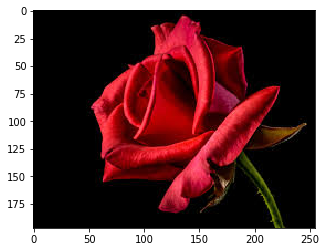

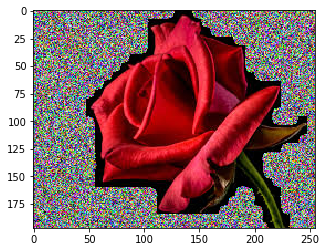

In [167]:
im_rose = bgr_rgb(cv2.imread("rose.jpeg", cv2.IMREAD_COLOR))
plot_image(im_rose)

def change_back(image, back_pixel=(0,0,0), back=None):
    back_mask = get_mask(image, back_pixel)
    if back is None:
        # random background
        back = np.random.randint(low=0, high=255, size=image.shape).astype("uint8")
    
    back_mask = np.logical_not(back_mask)
    # clean mask
    back_mask = (cv2.erode(cv2.dilate((back_mask*255).astype("uint8"), mp.disk(5)), mp.disk(5))/255).astype("bool")
    back[back_mask] = image[back_mask]
    return back

plot_image(change_back(im_rose))


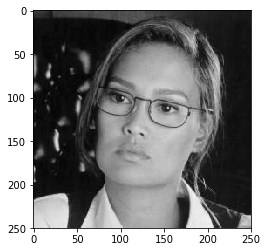

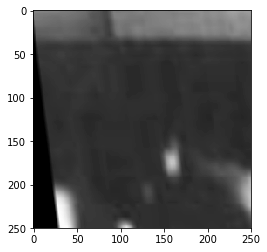

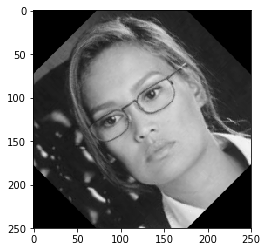

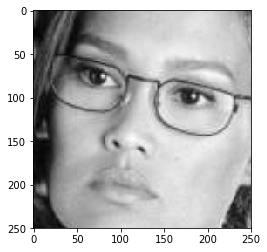

In [216]:
im_face = cv2.imread("face.jpg", cv2.IMREAD_GRAYSCALE)
plot_image(255 - im_face)

h, w = im_face.shape

scale = 4

T_my = np.array([
    [4, 1/2, 0],
    [0 , 4, 0]
], dtype="float")

# T = cv2.getRotationMatrix2D( ( point x, point y ), angle, scale)
T_rotate = cv2.getRotationMatrix2D( ( int(h/2), int(w/2) ), 45, 1)

T_scale = cv2.getRotationMatrix2D( ( int(h/2), int(w/2) ), 0, 2)

# points_before = np.array([
#     [10,10],
#     [100,100],
#     [103,10]
# ], dtype="float")

# points_after = np.array([
#     [10,10],
#     [100,100],
#     [103,10]
# ], dtype="float")

# T_point_trans = cv2.getAffineTransform(points_before, points_after)

plot_image(255 - cv2.warpAffine( im_face, T_my, im_face.shape ))

plot_image(255 - cv2.warpAffine( im_face, T_rotate, im_face.shape ))

plot_image(255 - cv2.warpAffine( im_face, T_scale, im_face.shape ))

# plot_image(255 - cv2.warpAffine( im_face, T_point_trans, im_face.shape ))

Align Face

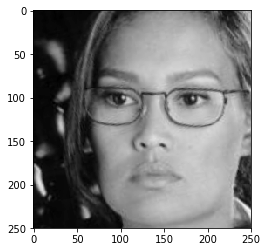

In [229]:
im_face = cv2.imread("face.jpg", cv2.IMREAD_GRAYSCALE)

eyes = np.array([
    [101,100],
    [154,111]
])

# plot_image(im_face)

def radian_to_degree(angle):
    return angle*180/np.pi

angle = radian_to_degree(np.arctan( (eyes[1][1]-eyes[0][1]) / (eyes[1][0]-eyes[0][0]) ))
T_rotate = cv2.getRotationMatrix2D( tuple(eyes[0]), angle, 1.5)
plot_image(255 - cv2.warpAffine( im_face, T_rotate, im_face.shape ))


# Homography Transform

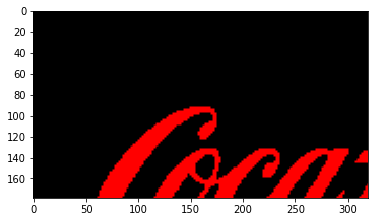

In [310]:
im_coke = bgr_rgb(cv2.imread("coca.jpg", cv2.IMREAD_COLOR))

def coke_thresh(image):
    h, w = image[:,:,0].shape
    mask = np.ones((h,w), dtype="bool")
    mask = np.logical_and(image[:,:,0] > 100, mask)
    mask = np.logical_and(image[:,:,1] < 100, mask)
    mask = np.logical_and(image[:,:,1] < 100, mask)
    
    r = (mask*255).astype("uint8")
    image_new = np.zeros((h,w,3), dtype="uint8")
    image_new[:,:,0] = r

    return image_new

im_coke = coke_thresh(im_coke)

# def random_points(image, points=4):
#     xs = np.random.randint(low=0, high=image.shape[1]-1, size=(points))
#     ys = np.random.randint(low=0, high=image.shape[0]-1, size=(points))
#     return np.float32(np.array([xs,ys]).T)

points_before = random_points(im_coke)
points_after = points_before*2

T = cv2.getPerspectiveTransform( points_before, points_after )

coke_new = cv2.warpPerspective( im_coke, T, (im_coke.shape[1], im_coke.shape[0]) )
plot_image(coke_new)

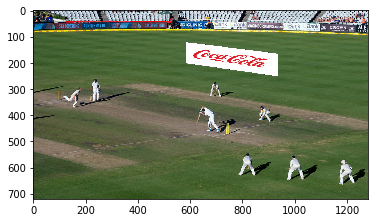

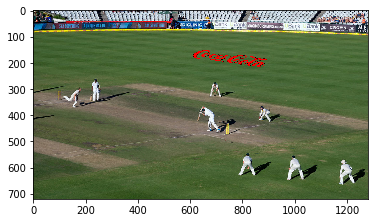

In [311]:
im_coke = bgr_rgb(cv2.imread("coca.jpg", cv2.IMREAD_COLOR))

h, w = im_coke[:,:,0].shape

points_before = np.float32(np.array([
    [0,0],
    [0,h-1],
    [w-1,0],
    [w-1,h-1]
]))

points_after = 2*np.float32(np.array([
    [292,61],
    [292,101],
    [468,83],
    [468,126]
]))

def overlay(image_back, image_front, points):
    image_back = deepcopy(image_back)
    mask = np.logical_not(get_mask(image_front, (0,0,0)))
    for i in range(3):
        image_back[:,:,i][mask] = 0
    image_back += image_front
    return image_back

T = cv2.getPerspectiveTransform( points_before, points_after )
coke_new = cv2.warpPerspective( im_coke, T, (im_stad.shape[1], im_stad.shape[0]) )
stad_new = overlay(im_stad, coke_new, point_after)
plot_image(stad_new)

im_coke = coke_thresh(im_coke)
T = cv2.getPerspectiveTransform( points_before, points_after )
coke_new = cv2.warpPerspective( im_coke, T, (im_stad.shape[1], im_stad.shape[0]) )
stad_new = overlay(im_stad, coke_new, point_after)
plot_image(stad_new)